# Phenomenological hydrodynamic equations with constant coeffcients in 1D

The density fields $\rho$ and momentum fields $\mathbf{m}$ are evolved according to
$$
\begin{align*}
\partial_t \rho &= -v_0 \nabla \cdot \mathbf{m}, \\
\partial_t \mathbf{m} + \xi (\mathbf{m} \cdot \nabla) \mathbf{m} &= D\nabla^2 \mathbf{m} - \lambda \nabla \rho + a_2 \mathbf{m} - a_4 |\mathbf{m}|^2 \mathbf{m},
\end{align*}
$$
where the transport coeffcients $v_0$, $\xi$, $D$, $\lambda$ and $a_4$ are constant, while keepging an explicit density dependence in $a_2:\ a_2(\rho)=\rho-\phi_g$, where $\phi_g$ is the gas spinodal, smaller than the liquid spinodal $\phi_l=\phi_g+\frac{1}{4a_4 v_0 + 2\lambda}$. 
Introducing $\mathbf{m} = (m_x, m_y)$, the equations become
$$
\begin{align*}
\partial_t \rho &= -v_0 (\partial_x m_x + \partial_y m_y),\\
\partial_t m_x + \xi (m_x \partial_x + m_y \partial_y) m_x & = D(\partial_x^2+\partial_y^2) m_x - \lambda \partial_x \rho + a_2 m_x - a_4 m^2 m_x,\\
\partial_t m_y + \xi (m_x \partial_x + m_y \partial_y) m_y & = D(\partial_x^2+\partial_y^2) m_y - \lambda \partial_y \rho + a_2 m_y - a_4 m^2 m_y,
\end{align*}
$$
where $m^2=|\mathbf{m}|^2=m_x^2+m_y^2$. In 1D, the equations can be simplifed as
$$
\begin{align*}
\partial_t \rho &= -v_0 \partial_x m, \\
\partial_t m + \xi m \partial_x m &= D\partial_x^2 m - \lambda \partial_x \rho + a_2 m - a_4 m^3,
\end{align*}
$$
where $m\equiv m_x$.

In Fourier space, we have 
$$
\begin{align*}
\partial_t \tilde{\rho} &= -iv_0 k \tilde{m}, \\
\partial_t \tilde{m} &= -\xi \left(
    \frac{i k}{2} \widetilde{m^2}
    \right) - k^2 D \tilde{m} - ik\lambda \tilde{\rho} + \widetilde{\rho m} - \phi_g\tilde{m} - a_4 \widetilde{m^3},
\end{align*}
$$
where $k\equiv k_x$.

In [6]:
import numpy as np
from coord import get_freq_1D
from fields import show_fields_1D, ini_fields_1D, dump_fields_1D

def eval_time_derivative_1D(rho, rho_hat, mx, mx_hat, kx, k2, v0, xi, D, lambdaa, phi_g, a4):
    mx2 = mx ** 2
    mx2_hat = np.fft.rfft(mx2)
    rho_mx_hat = np.fft.rfft(rho * mx)
    m3_hat = np.fft.rfft(mx2 * mx)

    f_rho = -1j * v0 * (kx * mx_hat)
    f_mx = -xi * 0.5j * kx * mx2_hat - (k2 * D + phi_g) * mx_hat - 1j * kx * lambdaa * rho_hat + rho_mx_hat - a4 * m3_hat
    return f_rho, f_mx


def exEulerFS_1D(rho_hat, mx_hat, kx, k2, v0, xi, D, lambdaa, phi_g, a4, dt):
    rho = np.fft.irfft(rho_hat)
    mx = np.fft.irfft(mx_hat)

    f_rho, f_mx = eval_time_derivative_1D(rho, rho_hat, mx, mx_hat, kx, k2, v0, xi, D, lambdaa, phi_g, a4)
    
    rho_hat_next = rho_hat + dt * f_rho
    mx_hat_next = mx_hat + dt * f_mx

    return rho_hat_next, mx_hat_next


def run_exEulerFS_1D(n_step, dn_out, dt, dx, fout, v0, xi, D, lambdaa, phi_g, a4, kx, k2, rho, mx, t0):
    n_frame = n_step // dn_out
    rho_hat =  np.fft.rfft(rho)
    mx_hat = np.fft.rfft(mx)

    Nx = rho.size
    rho_arr, mx_arr = np.zeros((2, n_frame, Nx))
    t_arr = np.zeros(n_frame)
    i_frame = 0
    for j in range(1, n_step+1):
        if j % dn_out == 0:
            t = t0 + dt * j
            rho = np.fft.irfft(rho_hat)
            mx = np.fft.irfft(mx_hat)
            dump_fields_1D(rho_arr, mx_arr, t_arr, rho, mx, t, i_frame)
            show_fields_1D(rho, mx, t, dx)
            i_frame += 1
        rho_hat, mx_hat = exEulerFS_1D(rho_hat, mx_hat, kx, k2, v0, xi, D, lambdaa, phi_g, a4, dt)
    
    # np.savez_compressed(fout, rho_arr=rho_arr, px_arr=px_arr, py_arr=py_arr, t_arr=t_arr)

In [7]:
dt = 1e-2
spacing = 0.4
Nx = 256 # Nx and Ny should be even
Lx = Nx * spacing

kx, k2 = get_freq_1D(Nx, spacing)

rho0 = 1. + 1/6 + 0.1
seed = 100
ini_mode = "rand"

v0 = 1.
lambdaa =1.
xi = 1.
D = 0.1
a4 = 1.
phi_g = 1.
np.random.seed(seed)

folder = "data_1D"
fout = f"{folder}/L{Lx:g}_r{rho0:g}_v{v0:g}_l{lambdaa:g}_a{a4:g}_g{phi_g}_dx{spacing:g}_dt{dt:g}_s{seed}.npz"

n_step = 4000000
dn_out = 200000

# rho, mx, t0 = ini_fields_1D(fout, ini_mode, spacing, Nx, rho0)
# mx += np.sqrt((rho0 - phi_g) / a4)
# run_exEulerFS_1D(n_step, dn_out, dt, spacing, fout, v0, xi, D, lambdaa, phi_g, a4, kx, k2, rho, mx, t0)

## Linearization around the ordered phase

Linearizing around the ordered solution $(\rho=\rho_0, m=m_0)$, where $m_0=\sqrt{(\rho_0-\phi_g)/a_4}$, the equation for the growth rate $\sigma$ reads 
$$
\sigma^2 + \left[q^2 D + iq\xi m_0 + 2 (\rho_0-\phi_g)\right]\sigma + iqv_0 (m_0 - iq\lambda) = 0. 
$$
The ordered solutions are linearaly linearly stable only when $\rho_0>\phi_l=\phi_g + \frac{1}{4a_4 v_0 + 2\lambda}$.

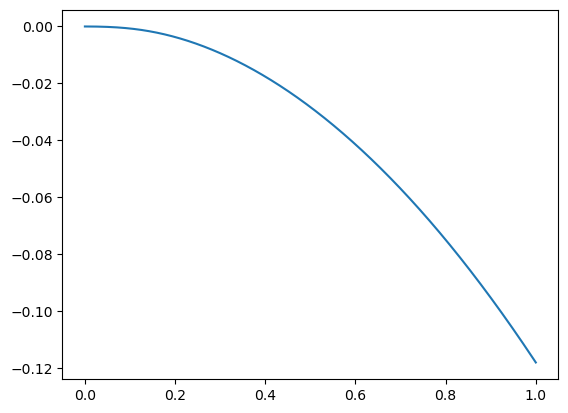

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def get_b(rho_0, q):
    m0 = np.sqrt((rho_0 - phi_g)/a4)
    return q**2 * D + 1j * q * xi * m0 + 2 * (rho_0 - phi_g)

def get_c(rho_0, q):
    m0 = np.sqrt((rho_0 - phi_g)/a4)
    return 1j * q * v0 * (m0 - 1j * q * lambdaa)

def get_sigma(rho_0, q):
    b = get_b(rho_0, q)
    c = get_c(rho_0, q)
    Delta = b**2 - 4 * c
    sigma = -b + np.sqrt(Delta)
    return sigma

v0 = 1.
lambdaa =1.
xi = 1
D = 0.1
a4 = 1.
phi_g = 1.
q = np.linspace(0, 1, 2000)
rho_0 = 1 + 1 / 6. + 0.001

sigma = get_sigma(rho_0, q)

plt.plot(q, sigma.real)

plt.show()
plt.close()